# Clasificación de Células Sanguíneas

En el proceso de diagnóstico de enfermedades, el estudio de la cantidad de células sanguíneas juega un papel importante para determinar factores que explican una enfermedad. En esta tarea, la idea es implementar el modelo de deep-learning más efectivo posible para clasificar células sanguíneas. Las clases de células sanguíneas son: [Eosinophil, Lymphocyte, Monocyte, Neutrophil]


In [1]:
#Instalamos el paquete gdown para poder descargar el dataset desde el gdrive
!pip install gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
#Descargamos el dataset
import gdown
output = 'blood.zip'
gdown.download(id='1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3', output=output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1CUQjT45tJmqNv_p2HcDkr4Z-IDQEbRg3
To: /content/blood.zip
100%|██████████| 105M/105M [00:01<00:00, 91.8MB/s]


'blood.zip'

In [3]:
# Descomprimimos el dataset
!unzip blood.zip

Streaming output truncated to the last 5000 lines.
  inflating: images/TRAIN/MONOCYTE/_0_4446.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4528.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_453.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4560.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4563.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4650.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4667.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4715.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4745.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4762.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4778.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4791.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4862.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4872.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4881.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4884.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_4925.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_494.jpeg  
  inflating: images/TRAIN/MONOCYTE/_0_5029.jpeg  
 

Implementa la mejor red neuronal posible. Tú decides si usas una red creada por ti mismo o si empleas transfer-learning. Entrena la red con los datos en la carpeta "TRAIN" y usa los datos en "VAL" como validación.

Para medir el performance final, realiza las inferencias sobre los datos del conjunto "TEST" y computa el accuracy sobre el conjunto de test. El accuracy es la proporción de imágenes para las cuales la predicción es correcta. IMPORTANTE: el accuracy de test se calcula una sola vez cuando hayas finalizado todos tus experimentos. Para tomar decisiones sobre el modelo y sus hiperparámetros solo puedes usar el conjunto de entrenamiento y validación.

Detalla todos los experimentos que hiciste y cómo llegaste a la mejor red neuronal reportada. Discute los resultados, comparando los distintos experimentos que tomaste en cuenta y responde a la pregunta: Porqué tu modelo final fue el mejor de todo lo que probaste?

IMPORTANTE: Evita el overfitting a toda costa. Un modelo con overfitting es aquel que durante el entrenamiento las curvas de loss/accuracy para datos de entrenamiento y validación se separan considerablemente. 

Éxitos!

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
import time
import os
import copy
from torchvision.io import read_image
from PIL import Image

In [78]:
class BloodDataset(torch.utils.data.Dataset):
  def __init__(self, root, split, transform):
    self.root = root
    self.split = split
    # self.class_type = class_type
    self.transform = transform

    self.class2idx = dict()

    self.class2idx['EOSINOPHIL'] = 0
    self.class2idx['LYMPHOCYTE'] = 1
    self.class2idx['MONOCYTE'] = 2
    self.class2idx['NEUTROPHIL'] = 3

    self.classes = ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']

    self.images = []
    self.labels = []

    for class_name in self.classes:
      files = os.listdir(f"{self.root}/{split}/{class_name}")
      for name in files:
        self.images.append(name)
        self.labels.append(class_name)
  
  def __len__(self):
    return len(self.images)
  
  def __getitem__(self, idx):
    image_path = os.path.join(self.root, self.split, self.labels[idx], self.images[idx])
    image = Image.open(image_path)
    label = self.class2idx[self.labels[idx]]
    im = image.convert('RGB')

    if self.transform:
      image = self.transform(im)
      
    return image, label

In [79]:
train_dataset = BloodDataset(root='images', split='TRAIN',
                                                transform=transforms.Compose([
                                                    transforms.RandomResizedCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                        std=[0.229, 0.224, 0.225])
                                                ]))
val_dataset = BloodDataset(root='images', split = 'VAL',
                                              transform=transforms.Compose([
                                                    transforms.Resize(256),
                                                    transforms.CenterCrop(224),
                                                    transforms. ToTensor(),
                                                    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                                         std=[0.229, 0.224, 0.225])
                                                ]))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader= torch.utils.data.DataLoader(val_dataset, batch_size=256, shuffle=True)

class_names = train_dataset.classes

def imshow(inp, title = None):
  plt.figure(figsize=(10,20))
  inp = inp.numpy().transpose((1, 2, 0))
  mean = np.array([0.5])
  std = np.array([0.5])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  
  if title is not None:
    plt.title(title)
  plt.pause(0.001)

In [80]:
print(val_dataset.labels[1:10])
print(val_dataset.images[1:10])

['EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL', 'EOSINOPHIL']
['_1_5031.jpeg', '_11_9310.jpeg', '_5_1744.jpeg', '_9_2814.jpeg', '_12_2599.jpeg', '_6_7701.jpeg', '_2_1226.jpeg', '_4_8814.jpeg', '_7_2284.jpeg']


In [81]:
print(val_dataset[3])

(tensor([[[0.8961, 0.8447, 0.7933,  ..., 0.8618, 0.8789, 0.8618],
         [0.8618, 0.8618, 0.8447,  ..., 0.9646, 0.9817, 0.9646],
         [0.8104, 0.8104, 0.7933,  ..., 0.9817, 0.9646, 0.9474],
         ...,
         [1.2214, 1.2728, 1.3927,  ..., 1.4612, 1.4612, 1.4440],
         [1.1700, 1.2385, 1.3584,  ..., 1.4783, 1.4783, 1.4612],
         [1.2385, 1.2728, 1.2899,  ..., 1.4783, 1.4783, 1.4954]],

        [[0.7829, 0.6604, 0.5378,  ..., 0.6078, 0.6078, 0.5903],
         [0.4503, 0.3803, 0.2927,  ..., 0.5553, 0.5728, 0.5903],
         [0.3627, 0.2927, 0.2227,  ..., 0.5553, 0.5728, 0.5903],
         ...,
         [1.0980, 1.2031, 1.3606,  ..., 1.7458, 1.7458, 1.7633],
         [1.0455, 1.1506, 1.2906,  ..., 1.7458, 1.7458, 1.7633],
         [1.0630, 1.0980, 1.1681,  ..., 1.7633, 1.7458, 1.7633]],

        [[1.2980, 1.3154, 1.3502,  ..., 1.0888, 1.1759, 1.2457],
         [1.6988, 1.7163, 1.6988,  ..., 1.2108, 1.2631, 1.2631],
         [1.6291, 1.6814, 1.6814,  ..., 1.2282, 1.2631, 1

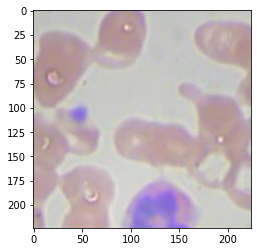

In [82]:
img = val_dataset[1][0]
inp = img.numpy().transpose((1, 2, 0))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
inp = std * inp + mean
inp = np.clip(inp, 0, 1)
  
  
plt.figure()
plt.imshow(inp.squeeze())
plt.show()

In [33]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
def train_model(model, criterio, optimizer, scheduler, num_epochs = 25):
  since = time.time()
  
  best_model_wts = copy.deepcopy(model.state_dict())
  best_acc = 0.0
  
  for epoch in range(num_epochs):
    print('Epoch {}/{}'.format(epoch, num_epochs-1))
    print('-' * 10)
    
    #Train model
    scheduler.step()
    model.train()
    
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
    
    epoch_loss = running_loss /len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)
      
    print('Train Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    #Validation 
    model.eval()
    running_loss = 0.0
    running_corrects = 0.0
    
    for inputs, labels in val_loader:
      inputs = inputs.to(device)
      labels = labels.to(device)
        
      with torch.set_grad_enabled(False):
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
          
      running_loss += loss.item() * inputs.size(0)
      running_corrects += torch.sum(preds == labels.data)
     
    epoch_loss = running_loss /len(val_dataset)
    epoch_acc = running_corrects.double() / len(val_dataset)
      
    print('Val Loss: {:.4f} Acc: {:.4f}'.format(epoch_loss, epoch_acc))
    
    if epoch_acc > best_acc:
        best_acc = epoch_acc
        best_model_wts = copy.deepcopy(model.state_dict())
        
  time_elapsed = time.time() - since
  print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed//60, time_elapsed % 60))
  print('Best val accucary: {:.4f}'.format(best_acc))

  model.load_state_dict(best_model_wts)
  return model

In [35]:
def visualize_model(model, num_images = 6):
  was_training = model.training
  model.eval()
  images_so_far = 0
  fig = plt.figure()
  
  with torch.no_grad():
    for i, (inputs, labels) in enumerate(val_loader):
      inputs = inputs.to(device)
      labels = labels.to(device)
      
      outputs = model(inputs)
      _, preds = torch.max(outputs, 1)
      
      for j in range(inputs.size()[0]):
        images_so_far +=1
        ax = plt.subplot(num_images//2, 2, images_so_far)
        ax.axis('off')
        ax.set_title('predicted: {}'.format(class_names[preds[j]]))
        imshow(inputs.cpu().data[j])
        
        if images_so_far == num_images:
          model.train(mode=was_training)
          return
    model.train(mode = was_training)
        

In [36]:
model_ft = models.resnet18(pretrained=True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [83]:
#Fine tuning
num_ft = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ft, 4)

model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

model_ft = train_model(model_ft, criterion, optimizer, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)


Train Loss: 1.2665 Acc: 0.4118
Val Loss: 0.8907 Acc: 0.6761
Epoch 1/24
----------
Train Loss: 0.8735 Acc: 0.6494
Val Loss: 0.5180 Acc: 0.9155
Epoch 2/24
----------


KeyboardInterrupt: ignored